# Calculating drainage area with `DAGGER`

In this notebook, we are illustrating different ways to calculate drainage area using the python wrapper of `DAGGER`. We explore the differences between single flow and multiple flow on a small DEM as well as how to weight drainage area spatially in order to simulate the effect of spatially variable precipitations.


## Setup

**Requirements: install the dependencies listed in the readme of the example folder**

First, let's import the relevant packages:
- `dagger` of course
- `helper` is a small local script (`helper.py`) using `rasterio/GDAL` to load DEMs
- `matplotlib` for the visualization
- `numpy` to manage arrays/matrix operations

In [1]:
import dagger as dag
from helper import load_raster
import matplotlib.pyplot as plt
import numpy as np

# The following line is a jupyter lab command telling it to use the interactive widget ipympl for matplotlib
%matplotlib widget

## Loading and preprocessing the DEM

`load_raster` is a simple function loading the input file into a dictionary with all the infos about the raster (dx,dy,nx,ny,...) as well as the array data. Preprocessing is done while computing the graph and ensure the local minima are solved and flow is not stopped midway through the DEM. For more detailed example about flow preprocessing, see the dedicated notebook.

In the following cell, we create the main objects required for `DAGGER` to work: 
- `con` is a `D8N` (D8 neighbours) and manages all the connections between nodes in the 8 directions (see dedicated notebook for more details)
- `gf` is the `graph` managing the graph operations
- `PPdem` is a numpy array storing the topography preprocessed after local minima solvers


In [2]:
dem = load_raster("putna_50_NDF.tif")
con = dag.D8N(dem["nx"], dem["ny"], dem["dx"], dem["dy"], dem["x_min"], dem["y_min"])
gf = dag.graph(dem["nx"] * dem["ny"], 8)
gf.init_graph(con)
PPdem = gf.compute_graph("cordonnier_carve", dem['array'].ravel(), con, False, True)
HS = dag.hillshade(con,PPdem)

## let's first visualize our DEM

In [6]:
diff = (PPdem - dem['array'].ravel()).reshape(dem['ny'],dem['nx'])


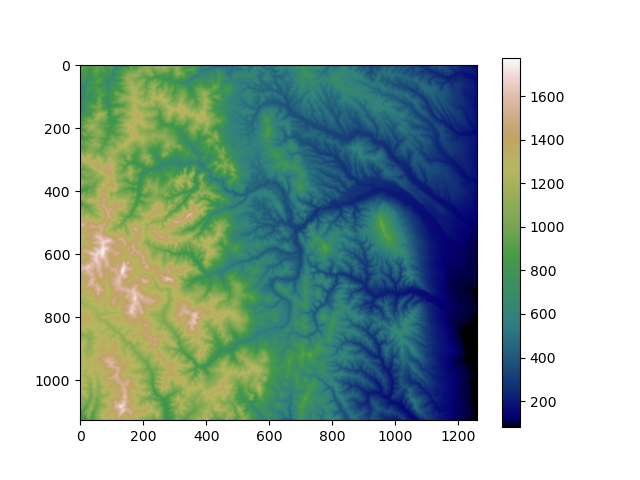

In [7]:
fig,ax = plt.subplots()
cb = ax.imshow(diff, cmap = "RdBu_r", vmin = -1e-5, vmax =1e-5)
cb = ax.imshow(PPdem.reshape(dem['ny'],dem['nx']), cmap = "gist_earth", vmin = 80)

plt.colorbar(cb)

In [8]:
A = gf.accumulate_constant_downstream_SFD(con,900)

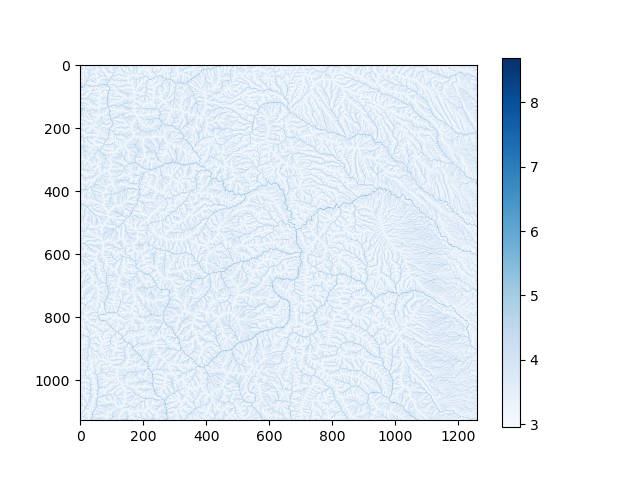

In [9]:
fig,ax = plt.subplots()

cb = ax.imshow(np.log10(A).reshape(dem['ny'],dem['nx']), cmap = "Blues")
ax.imshow(PPdem.reshape(dem['ny'],dem['nx']), cmap = "gist_earth", alpha =0)

plt.colorbar(cb)

In [10]:
gradient = gf.get_links_gradient(con, PPdem)
weights = gf.get_link_weights(gradient,0.8)
A = gf.accumulate_constant_downstream_MFD(con,weights,900)

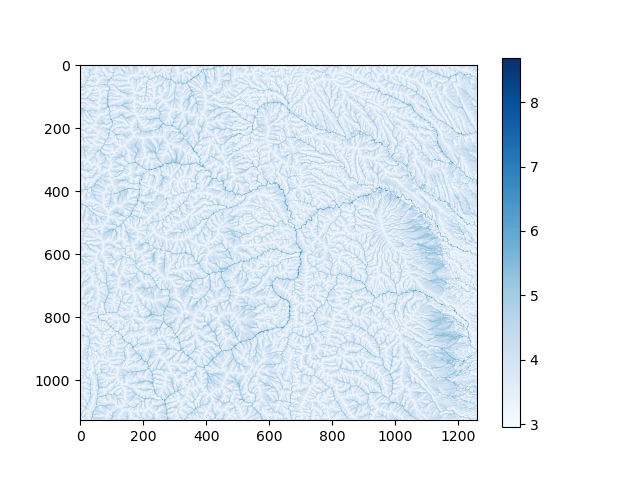

In [11]:
fig,ax = plt.subplots()

cb = ax.imshow(np.log10(A).reshape(dem['ny'],dem['nx']), cmap = "Blues")
# ax.imshow(PPdem.reshape(dem['ny'],dem['nx']), cmap = "gist_earth", alpha =0)

plt.colorbar(cb)

In [12]:
PPdem.reshape(dem['ny'],dem['nx'])[532,1142] - PPdem.reshape(dem['ny'],dem['nx'])[532,1143]

0.0035400390625

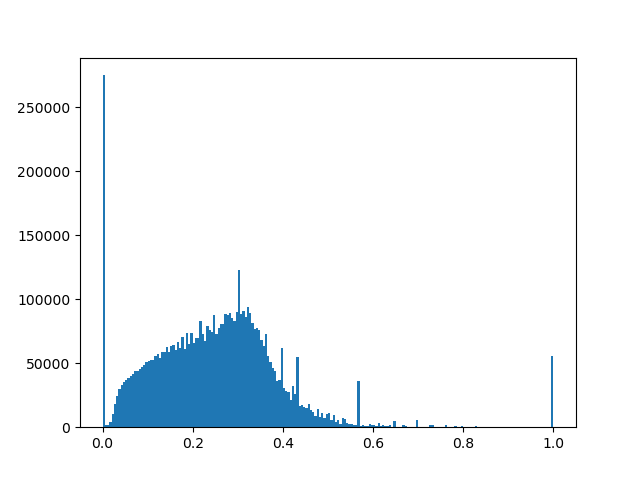

In [13]:
fig,ax = plt.subplots()
ap = ax.hist(weights, bins = 200)

In [14]:
np.unique(weights)

array([0.00000000e+00, 7.61992652e-07, 1.20414841e-06, ...,
       9.99997965e-01, 1.00000000e+00,            nan])